# Spiraling out of Neural Nets

**Dan Lu**

## Spiral Point Classification

Here's the scary looking parametric function:

$$
X_k(t) = t \left( \begin{array}{c} {\sin \left[ {{2 \pi} \over {K}} (2t + k - 1) \right]} \\ {\cos \left[ {{2 \pi} \over {K}} (2t + k - 1) \right]} \end{array} \right)
$$

#### do stuff

In [1]:
import torch
from torch import nn, optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torch.functional as F

import fastbook
from fastbook import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
seed = 12345
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
K = 3     # num_classes

In [3]:
# Generate spirals

t = torch.linspace(0, 1, N)
a = 0.8 * t + 0.2  # amplitude 0.2 → 1.0
X = list()
y = list()
for k in range(K):
    θ = (2 * t + k) * 2 * torch.pi / K + 0.2 * torch.randn(N)
    X.append(torch.stack((a * θ.sin(), a * θ.cos()), dim=1))
    y.append(torch.zeros(N, dtype=torch.long).fill_(k))
X = torch.cat(X)
y = torch.cat(y)

#### show stuff

Here's the pretty looking plot!

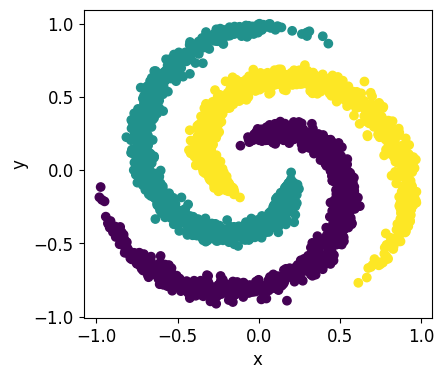

In [4]:
plt.figure(figsize=(4.5, 4))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('x')
plt.ylabel('y')

plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])

plt.show()

### The Task

Give a neural net:
- the $X = (x, y)$ coordinates of each point 
- predict which of the $K=3$ spirals it belongs to.


#### This is non-trivial because spiral points are not linearly separable!


##

- 
-
- 




## Sandwich Analogy

> #### $A \space neural \space net \space has \space to \space be \space like \space a \space sandwich \space of \space linear \space and \space nonlinear \space layers...$

- `Linear` layers are like bread.
- `ReLU` nonlinear layers are like stuff you put in between bread.
- without nonlinear layers, you would just have a stack of bread...AND THAT'S NOT A SANDWICH!

<img src="lin-nonlin.png">

source: [Scanwich](https://twistedsifter.com/2013/01/scanwiches-cross-sections-of-sandwiches-by-jon-chonko/) (a great website!)

In [5]:
class DeepLinear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # BREAD
            nn.Linear(hidden_size, hidden_size), # BREAD            <= NOT A SANDWICH!
            nn.Linear(hidden_size,output_size)   # BREAD
        )
    
    def forward(self, xb):
        score = self.net(xb)
        return score

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # BREAD
            nn.ReLU(),                           # STUFF
            nn.Linear(hidden_size, hidden_size), # BREAD           <= THAT'S A SANDWICH!
            nn.ReLU(),                           # STUFF
            nn.Linear(hidden_size,output_size)   # BREAD
        )
    def forward(self, xb):
        score = self.net(xb)
        return score


### do stuff

In [7]:
class ToyDataset(Dataset):
    def __init__(self, X, y, split=0.2):
        self.features = X
        self.labels = y
    
    def __getitem__(self, index):
        x_item = self.features[index]
        y_item = self.labels[index]
        return x_item, y_item
    
    def __len__(self):
        return self.labels.shape[0]

In [8]:
whole_ds = ToyDataset(X=X, y=y)
# len(whole_ds)

In [9]:
def split_dataset(ds, train_percent=0.8):
    """
    ds - ToyDataset
    """

    train_size = int(len(ds) * train_percent)
    test_size = len(ds) - train_size

    train_subset, test_subset = random_split(ds, [train_size, test_size])

    X_train = ds.features[train_subset.indices]
    y_train = ds.labels[train_subset.indices]

    X_test = ds.features[test_subset.indices]
    y_test = ds.labels[test_subset.indices]

    train_ds = ToyDataset(X_train,y_train)
    test_ds = ToyDataset(X_test,y_test)
    
    return train_ds, test_ds

In [10]:
train_ds, test_ds = split_dataset(whole_ds)

In [11]:
torch.manual_seed(1337)

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=32,
    shuffle=False,
    drop_last=True,
    num_workers=0
)

In [12]:
def train_epoch(model, train_loader, optim):
    # set model to train
    model.train()

    for idx, (xb, yb) in enumerate(train_loader):
        # forward pass
        score = model(xb)
        
        # cross-entropy loss 
        loss = F.cross_entropy(score, yb)

        # accuracy
        preds = torch.argmax(score, dim=-1)
        acc = ((preds - yb) == 0).float().mean().item()

        # clear old gradient from previous backprop
        optim.zero_grad()

        # compute new gradient and backprop
        loss.backward()

        # update parameter step
        optim.step()

    # set model back to eval in case 
    # other code wants to do that by default
    model.eval()

    return model, loss.item(), acc
    

In [13]:
def test_epoch(model, test_loader):
    
    # no gradient calculations
    with torch.no_grad():
        for idx, (xb, yb) in enumerate(test_loader):
            # model output
            score = model(xb)

            # loss
            loss = F.cross_entropy(score, yb)

            # accuracy
            preds = torch.argmax(score, dim=-1)
            acc = ((preds - yb) == 0).float().mean().item()
    
    return loss.item(), acc

In [14]:
def train_test(model, train_loader, test_loader, optim, epochs=100, verbose=False):
    for e in range(epochs):
        model, train_loss, train_acc = train_epoch(model, train_loader, optim)
        test_loss, test_acc = test_epoch(model, test_loader)

        if verbose:
            if (e % 10 == 0) or (e == epochs-1):
                print(f"[Epoch {e}] Train/Test Loss: {train_loss:.2f} / {test_loss:.2f} | Train/Test Acc: {train_acc*100:.1f}% / {test_acc*100:.1f}%")
    return model

In [ ]:
torch.manual_seed(1337)

linear_model = DeepLinear(input_size = 2, hidden_size = 10, output_size = 3)
optim = torch.optim.AdamW(linear_model.parameters(), lr=1e-3)

linear_model = train_test(linear_model, train_loader, test_loader, optim, verbose=True, epochs=2_000)

In [ ]:
torch.manual_seed(1337)

model = MLP(input_size = 2, hidden_size = 10, output_size = 3)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

model = train_test(model, train_loader, test_loader, optim, verbose=True, epochs=2_000)

In [17]:
linear_preds = torch.argmax(linear_model(X), dim=-1)
preds = torch.argmax(model(X), dim=-1)

### show stuff

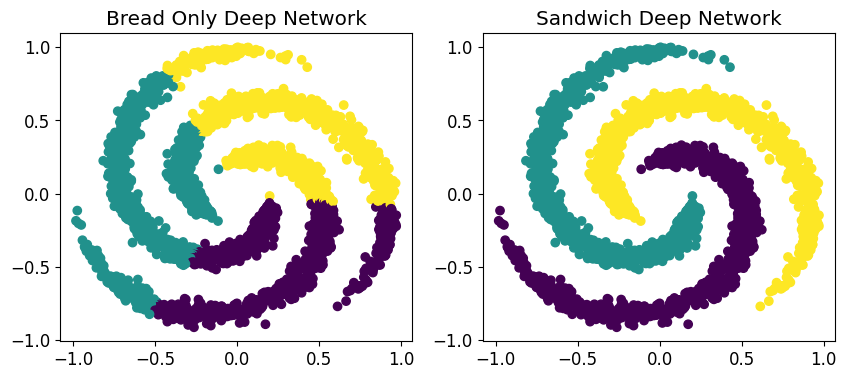

In [18]:
# show all points in side-by-side subplots: model prediction vs ground truth 
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(X[:,0], X[:,1], c=linear_preds)
ax[1].scatter(X[:,0], X[:,1], c=preds)

ax[0].set_title('Bread Only Deep Network')
ax[1].set_title('Sandwich Deep Network')

for a in ax:
    a.set_xticks([-1, -0.5, 0, 0.5, 1])
    a.set_yticks([-1, -0.5, 0, 0.5, 1])

plt.show()

#### Without non-linear layers, you will not have a well performing neural network...no matter how "deep" it is!

##

- 
-
- 




## Bread Dough Analogy

> #### $A \space neural \space net \space transforms \space data \space like \space rolling \space bread \space dough...$

- `Linear` layers **rotate** the data
- `ReLU()` non-linear layers **squash** the data
- the neural net ulimately learns how much **rotating** + **squashing** + **rotating** + **squashing** to do
- UNTIL the data IS linearly separable!

<img src="rotate-squash.png">

source: [How to knead bread dough](https://www.youtube.com/watch?v=BJiucv88flM)

### How can we visualize this?

- the deep neural net's hidden layers are dealing in 10 dimensional space
- we can only plot 2D or 3D...

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=10, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # BREAD
            nn.ReLU(),                           # STUFF
            nn.Linear(hidden_size, hidden_size), # BREAD           <= THAT'S A SANDWICH!
            nn.ReLU(),                           # STUFF
            nn.Linear(hidden_size,output_size)   # BREAD
        )
    def forward(self, xb):
        score = self.net(xb)
        return score


### Solution: Add 2 dimensional bread...

Add linear layers that project from 10-D back down to 2-D space (i.e., visualize the 2D embeddings)

In [20]:
class MLPemb(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__() 

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), # BREAD
            nn.ReLU(),                          # STUFF
            nn.Linear(hidden_size,2),           # THIN BREAD SLICE => GET 2-D output
            nn.Linear(2, hidden_size),          # THIN BREAD SLICE                         <= PRETTY MUCH THE SAME SANDWICH
            nn.ReLU(),                          # STUFF
            nn.Linear(hidden_size,2),           # THIN BREAD SLICE => GET 2-D output
            nn.Linear(2,output_size)            # THIN BREAD SLICE
        )
    
    def forward(self, xb):
        score = self.net(xb)
        return score


### do stuff

In [ ]:
torch.manual_seed(1337)

model = MLPemb(input_size = 2, hidden_size = 10, output_size = 3)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

model = train_test(model, train_loader, test_loader, optim, verbose=True, epochs=2_000)

In [22]:
# empty dictionary for storing outputs of any layer
layer_outputs = {}

def get_layer_outputs(name):
    
    def hook(model, input, output):
        layer_outputs[name] = output
    
    return hook

In [23]:
# visualize the second to last layer output in 2D

# identify the layer we want outputs from
layer1 = model.net[2] # layer after first ReLU
layer2 = model.net[-2] # second to last layer

# register forward hook
layer1.register_forward_hook(get_layer_outputs('first_emb'))
layer2.register_forward_hook(get_layer_outputs('last_emb'))

# forward pass through model
# store outputs into layer_outputs dictionary
with torch.no_grad():
    scores = model(X)

h1 = layer_outputs['first_emb']
h2 = layer_outputs['last_emb']

preds = torch.argmax(scores, dim=-1)

### show stuff

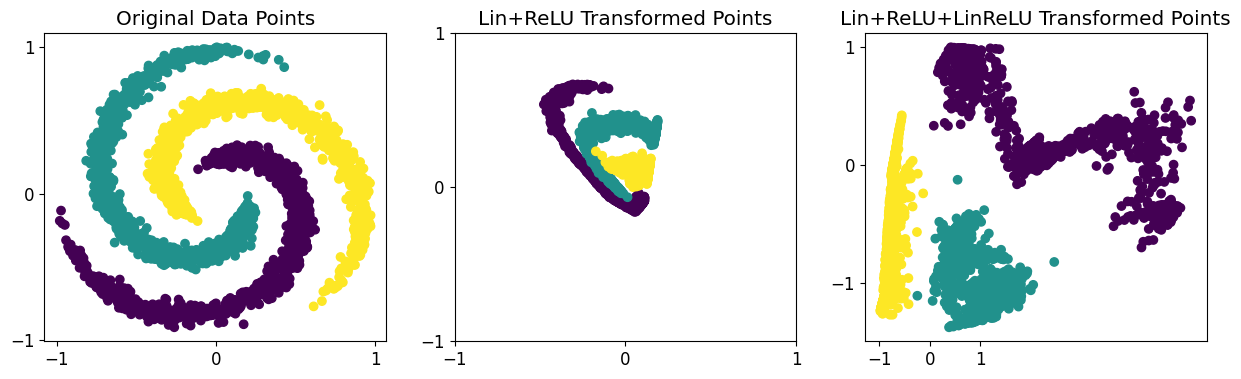

In [24]:
# show all points in side-by-side subplots: model prediction vs ground truth 
fig, ax = plt.subplots(1,3, figsize=(15,4))

ax[0].scatter(X[:,0], X[:,1], c=y)
ax[1].scatter(h1[:,0], h1[:,1], c=y)
ax[2].scatter(h2[:,0], h2[:,1], c=y)

ax[0].set_title('Original Data Points')
ax[1].set_title("Lin+ReLU Transformed Points")
ax[2].set_title("Lin+ReLU+LinReLU Transformed Points")

for a in ax:
    a.set_xticks([-1, 0, 1])
    a.set_yticks([-1, 0, 1])

plt.show()

#### A neural net learns to transform (*rotation + squashing*) the *not-linearly separable* data into *linearly separable* groups.

In theory, a neural net can approximate *any given function by* finding a combination of simpler linear and non-linear function parameters to mimic that *given function*.

##

- 
-
- 




## Creative Coding with Neural Nets

> #### $Let's \space make \space a \space rainbow \space sandwich...$

- the neural net doesn't assign physical meaning to the multidimensional data in the hidden layers
- the neural net is not trying to make art...
- ...but I am :D

In [ ]:
class MLPdeep(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__() # IMPORTANT

        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(), # ===============================> 6-D output => map to ['x', 'y', 'R', 'G', 'B', 's']  #1
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), # ===============================> 6-D output => map to ['x', 'y', 'R', 'G', 'B', 's']  #3
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), # ===============================> 6-D output => map to ['x', 'y', 'R', 'G', 'B', 's']  #5
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), # ===============================> 6-D output => map to ['x', 'y', 'R', 'G', 'B', 's']  #7
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), # ===============================> 6-D output => map to ['x', 'y', 'R', 'G', 'B', 's']  #9
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, xb):
        score = self.net(xb)
        return score


In [42]:
model

MLPdeep(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): ReLU()
    (6): Linear(in_features=6, out_features=6, bias=True)
    (7): ReLU()
    (8): Linear(in_features=6, out_features=6, bias=True)
    (9): ReLU()
    (10): Linear(in_features=6, out_features=3, bias=True)
  )
)

In [26]:
features = ['x', 'y', 'R', 'G', 'B', 's']
    

### do stuff

In [27]:
size_scale = 10

In [ ]:
torch.manual_seed(1337)

model = MLPdeep(input_size = 2, hidden_size = 6, output_size = 3)
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

model = train_test(model, train_loader, test_loader, optim, verbose=True, epochs=2_000)

In [30]:
# visualize the second to last layer output in 2D
layer_outputs = {}

relus = [model.net[i] for i in range(10) if i % 2 == 0]


# register forward hook
for i, relu in enumerate(relus):
    relu.register_forward_hook(get_layer_outputs(f'relu{i+1}'))


# forward pass through model
# store outputs into layer_outputs dictionary
with torch.no_grad():
    scores = model(X)
    preds = torch.argmax(scores, dim=-1)

layer_outputs['relu1'].shape

torch.Size([3000, 6])

In [31]:
layer_outputs.keys()

dict_keys(['relu1', 'relu2', 'relu3', 'relu4', 'relu5'])

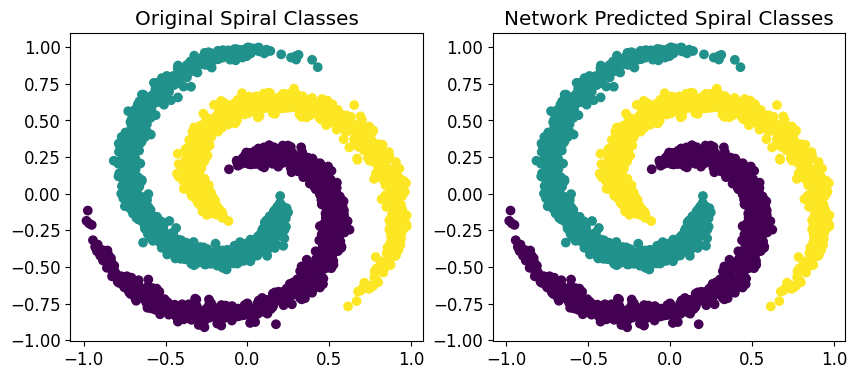

In [32]:
# show all points in side-by-side subplots: model prediction vs ground truth 
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(X[:,0], X[:,1], c=y)
ax[1].scatter(X[:,0], X[:,1], c=preds)

ax[0].set_title('Original Spiral Classes')
ax[1].set_title('Network Predicted Spiral Classes')
plt.show()

In [33]:
idx = torch.randperm(len(features))[:len(features)]
feature_map = [features[i] for i in list(idx)]
print(idx)
print(feature_map)

tensor([2, 3, 5, 1, 4, 0])
['R', 'G', 's', 'y', 'B', 'x']


In [34]:
def hidden_to_dot_features(h_out, norm=None, idx=None):
    
    def minmax(x, dim=None, eps=1e-8):
        if dim is None:
            return (x - x.min()) / (x.max() - x.min()) + eps
        x_min = x.min(dim=dim, keepdim=True).values
        x_max = x.max(dim=dim, keepdim=True).values
        return (x - x_min) / (x_max - x_min) + eps
    
    # decide on normalization scheme
    if norm == None:
        h_out = h_out
    elif norm == 'softmax':
        h_out = torch.softmax(h_out, dim=-1)
    elif norm == 'sigmoid':
        h_out = torch.sigmoid(h_out)
    elif norm == 'minmax':
        h_out = minmax(h_out, dim=-1)
    else:
        return ValueError("Invalid norm scheme, choose from ['softmax', 'sigmoid', 'minmax']")
    
    if idx == None:
        idx = torch.randperm(len(features))[:len(features)]
    
    feature_map = [features[i] for i in list(idx)]
    # print(idx, feature_map)

    # Split into separate arrays
    x = h_out[:, idx[0]]
    y = h_out[:, idx[1]]

    colors_r = h_out[:, idx[2]]  
    colors_g = h_out[:, idx[3]]  
    colors_b = h_out[:, idx[4]]  
    colors = torch.stack((colors_r,colors_g,colors_b), dim=1)
    
    sizes = (h_out[:, idx[5]])
    # normalize first (optional but helps keep things consistent)
    sizes = (sizes - sizes.min()) / (sizes.max() - sizes.min())

    # apply exponential scaling
    sizes = torch.exp(3 * sizes) * 100  # tweak the multiplier (3) and base size (20)

    if norm == None:
        colors = minmax(colors, dim=-1)
        sizes = minmax(sizes, dim=-1)

    return (x, y, colors, sizes), idx

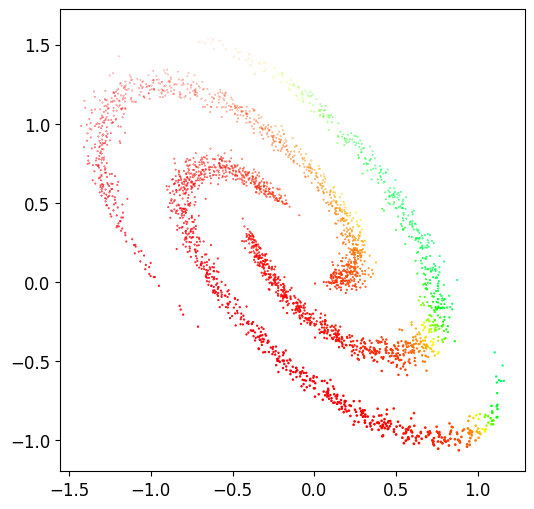

In [35]:
dot_features, idx = hidden_to_dot_features(h_out=layer_outputs['relu1'])
x, y, colors_in, sizes_in = dot_features

plt.figure(figsize=(6, 6))

plt.scatter(
    x,
    y,
    s=sizes_in,
    c=colors_in
)

plt.show()

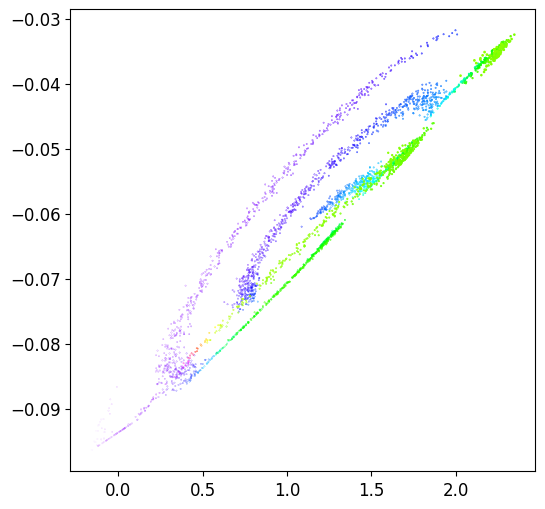

In [36]:
dot_features, idx = hidden_to_dot_features(h_out=layer_outputs['relu2'], idx=idx)
x, y, colors_in, sizes_in = dot_features

plt.figure(figsize=(6, 6))

plt.scatter(
    x,
    y,
    s=sizes_in,
    c=colors_in
)
plt.show()

In [37]:
def plot_sandwich(idx=None, fix_scale=False):


    keys = layer_outputs.keys()
    n_relus = len(keys)

    fig, ax = plt.subplots(n_relus,1, figsize=(5.5, 5.5*n_relus))
    # Turn on dark mode manually
    fig.patch.set_facecolor("black")      # entire figure background

    for a in ax.ravel():
        a.set_facecolor("black")
        a.tick_params(colors="white")
        a.xaxis.label.set_color("white")
        a.yaxis.label.set_color("white")
        a.title.set_color("white")
        for spine in a.spines.values():
            spine.set_color("white")

    if fix_scale:
        # Collect limits first
        xmins, xmaxs, ymins, ymaxs = [], [], [], []

        for i, k in enumerate(keys):
            dot_features, idx = hidden_to_dot_features(h_out=layer_outputs[k], idx=idx)
            x, y, colors, sizes = dot_features
            xmins.append(x.min())
            xmaxs.append(x.max())
            ymins.append(y.min())
            ymaxs.append(y.max())

        # Compute global bounds
        xlim = (min(xmins), max(xmaxs))
        ylim = (min(ymins), max(ymaxs))

    # Now plot with fixed limits
    for i, k in enumerate(keys):
        dot_features, idx = hidden_to_dot_features(h_out=layer_outputs[k], idx=idx)
        x, y, colors, sizes = dot_features

        ax[i].scatter(x, y, s=sizes, c=colors)
        if fix_scale:
            ax[i].set_xlim(xlim)
            ax[i].set_ylim(ylim)
            ax[i].set_aspect('equal', adjustable='box')
        ax[i].set_title(k)

    plt.tight_layout()
    plt.show()

### show stuff

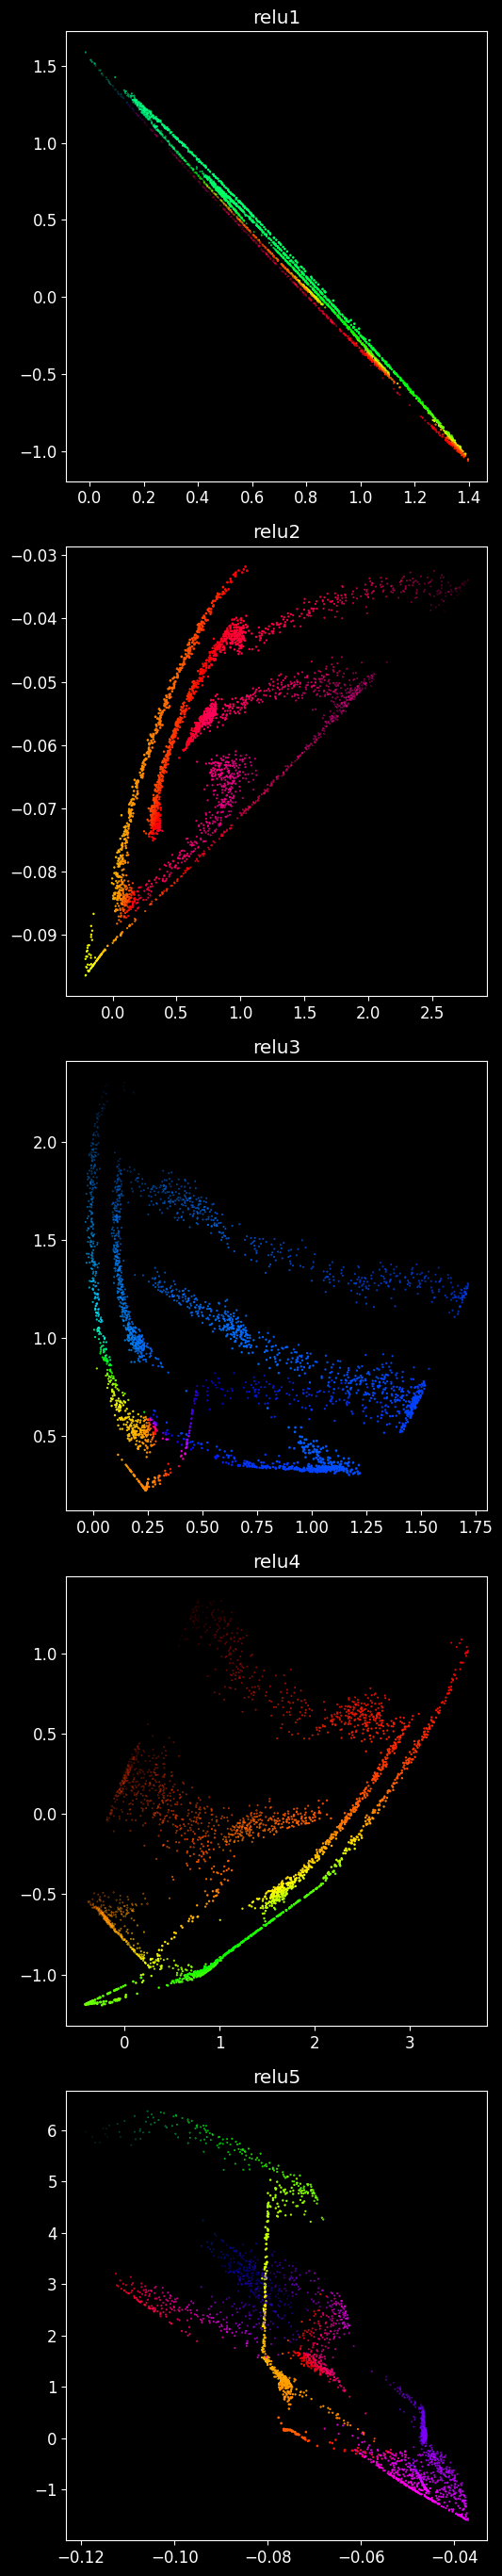

In [38]:
# tensor([5, 4, 1, 2, 3, 0]) ['s', 'B', 'y', 'R', 'G', 'x']

idx = [5, 4, 1, 2, 3, 0]
plot_sandwich(idx)


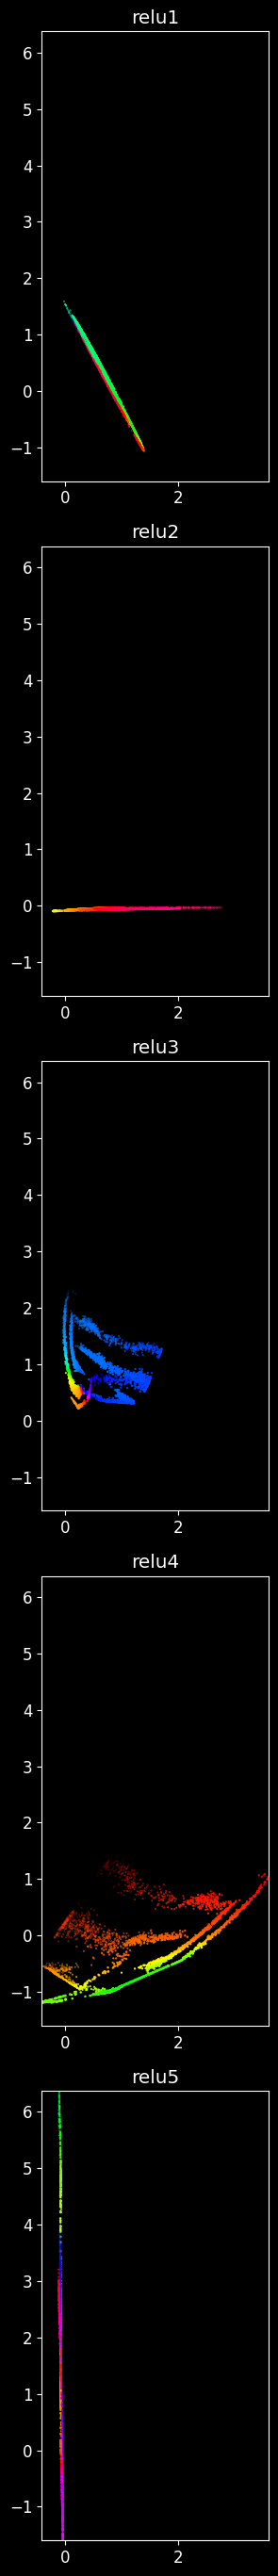

In [39]:
# tensor([5, 4, 1, 2, 3, 0]) ['s', 'B', 'y', 'R', 'G', 'x']
plot_sandwich(idx, True)


[5, 0, 1, 4, 3, 2]
['s', 'x', 'y', 'B', 'G', 'R']


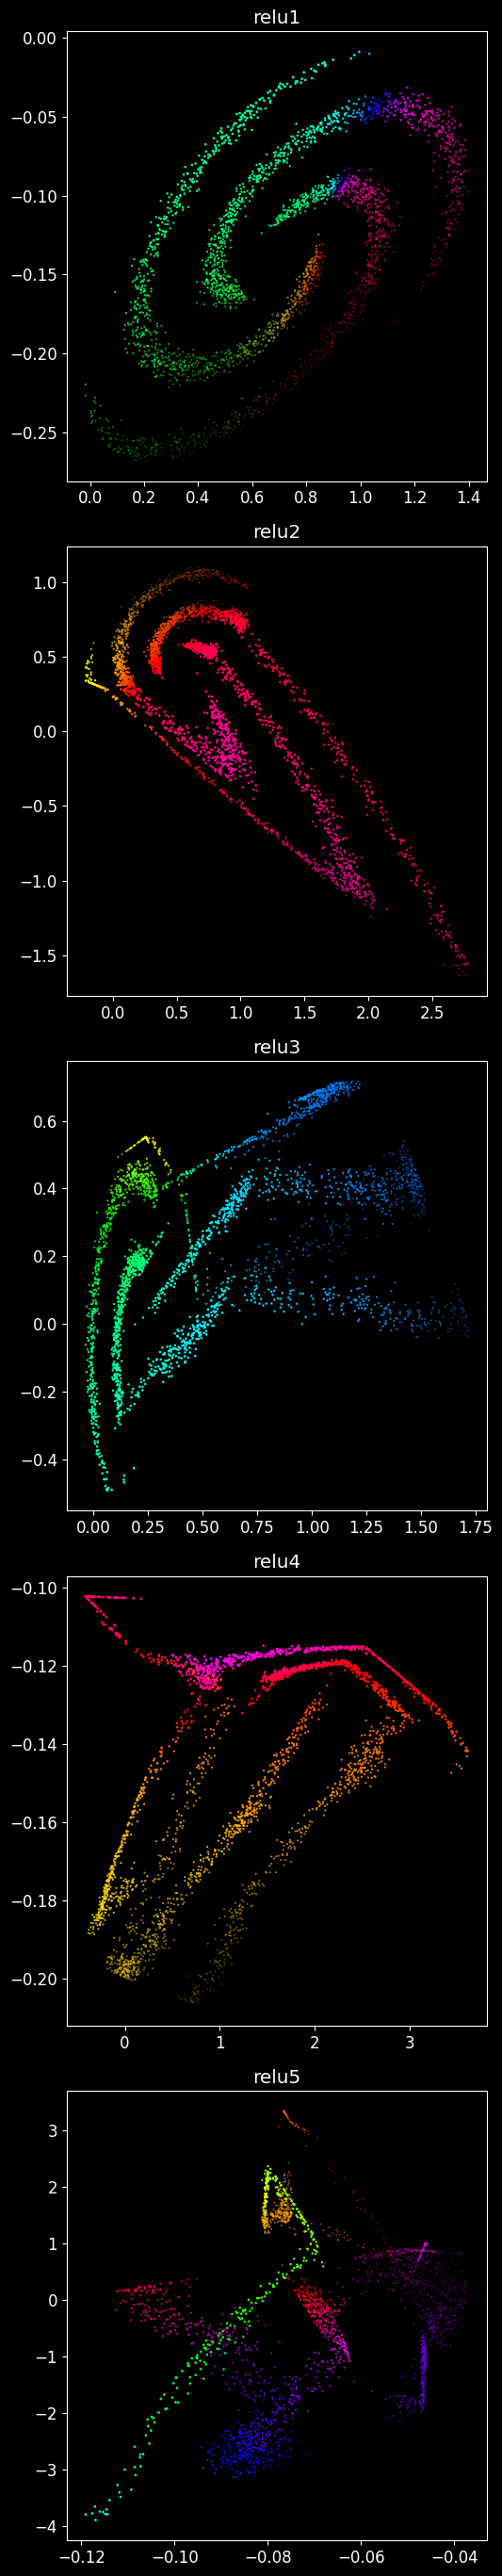

In [40]:
idx = [5, 0, 1, 4, 3, 2]
feature_map = [features[i] for i in list(idx)]
print(idx)
print(feature_map)
plot_sandwich(idx)


[0, 5, 1, 4, 3, 2]
['x', 's', 'y', 'B', 'G', 'R']


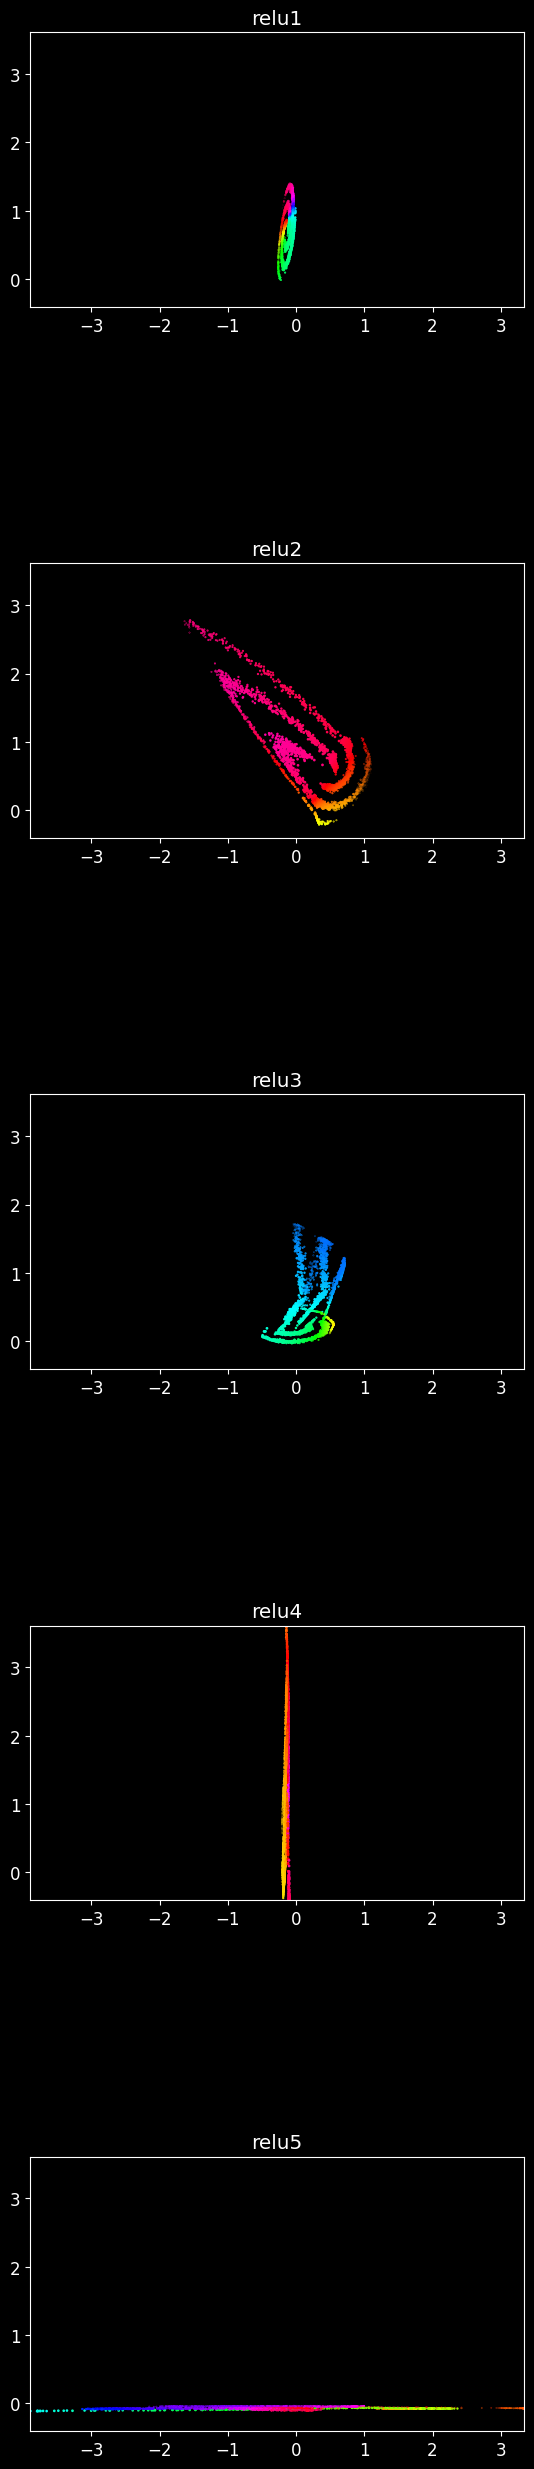

In [41]:
idx = [0, 5, 1, 4, 3, 2]
feature_map = [features[i] for i in list(idx)]
print(idx)
print(feature_map)
plot_sandwich(idx, True)


## Credits

This notebook was largely inspired by [Alfredo Canziani](https://github.com/Atcold) when I took the NYU Deep Learning course in Fall 2021. Specifically these two recitation topics really opened up my eyes to how deep neural nets work at a fundamental level:

 - Spiral classification: [Lecture](https://www.youtube.com/watch?v=EyKiYVwrdjE) | [Notebook](https://github.com/Atcold/NYU-DLSP21/blob/master/04-spiral_classification.ipynb) | [Notes](https://atcold.github.io/NYU-DLSP20/en/week02/02-3/)
 - Linear vs Non-linear transformations: [Lecture](https://www.youtube.com/watch?v=panJ-pkaqBQ) | [Notebook](https://github.com/Atcold/NYU-DLSP20/blob/master/02-space_stretching.ipynb) | [Notes](https://atcold.github.io/NYU-DLSP20/en/week01/01-3/)

I hope that this notebook here distills the key concepts and combines the various details of the above discussions into a single "spiral show."